# Example 2: Asset statistics
This tutorial follows from [Tutorial 1](https://github.com/dcelisgarza/PortfolioOptimiser.jl/blob/main/examples/0_basic_use.ipynb). If something in the preamble is confusing, it is explained there.

This tutorial focuses on the computation of asset statistics.

## 1. Downloading the data

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "MarketData", "Clarabel", "HiGHS", "CovarianceEstimation"])
using Clarabel, CovarianceEstimation, DataFrames, Dates, GraphRecipes, HiGHS, MarketData,
      PortfolioOptimiser, Statistics, StatsBase, StatsPlots, TimeSeries

assets = Symbol.(["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC",
                  "LULU", "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT",
                  "SAVE", "SBUX", "SIRI", "STX", "TLRY", "TSLA"])

Date_0 = DateTime(2019, 01, 01)
Date_1 = DateTime(2023, 01, 01)

function get_prices(assets)
    prices = TimeSeries.rename!(yahoo(assets[1],
                                      YahooOpt(; period1 = Date_0, period2 = Date_1))[:AdjClose],
                                assets[1])
    for asset ∈ assets[2:end]
        # Yahoo doesn't like regular calls to their API.
        sleep(rand() / 10)
        prices = merge(prices,
                       TimeSeries.rename!(yahoo(asset,
                                                YahooOpt(; period1 = Date_0,
                                                         period2 = Date_1))[:AdjClose],
                                          asset), :outer)
    end
    return prices
end

prices = get_prices(assets)

1008×25 TimeSeries.TimeArray{Float64, 2, Dates.Date, Matrix{Float64}} 2019-01-02 to 2022-12-30
┌────────────┬─────────┬─────────┬─────────┬──────┬─────────┬─────────┬─────────
│            │ AAL     │ AAPL    │ AMC     │ BB   │ BBY     │ DELL    │ DG     ⋯
├────────────┼─────────┼─────────┼─────────┼──────┼─────────┼─────────┼─────────
│ 2019-01-02 │ 31.9632 │ 37.7501 │ 119.143 │ 7.11 │ 44.0813 │  22.371 │ 101.37 ⋯
│ 2019-01-03 │ 29.5817 │ 33.9899 │ 120.715 │ 6.88 │ 43.1767 │ 21.4262 │   101. ⋯
│ 2019-01-04 │ 31.5302 │ 35.4409 │ 125.151 │ 7.23 │ 43.3823 │ 21.8487 │ 102.37 ⋯
│ 2019-01-07 │ 32.4257 │  35.362 │ 130.512 │ 7.43 │ 45.8578 │ 21.9911 │ 106.58 ⋯
│ 2019-01-08 │ 31.9041 │ 36.0361 │ 134.672 │ 7.41 │ 47.2065 │ 22.2523 │ 107.09 ⋯
│ 2019-01-09 │ 32.8882 │ 36.6481 │ 128.941 │ 7.47 │ 47.5602 │ 22.2855 │   109. ⋯
│ 2019-01-10 │ 31.5302 │ 36.7652 │ 126.907 │ 7.52 │ 46.7706 │ 21.4547 │ 109.96 ⋯
│ 2019-01-11 │  31.294 │ 36.4042 │  129.68 │ 7.57 │ 46.4746 │ 21.1128 │ 109.52 ⋯
│     ⋮      │

## 2. Instantiating an instance of `Portfolio`.

In [2]:
portfolio = Portfolio(; prices = prices,
                      # Continuous optimiser.
                      solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                       :check_sol => (allow_local = true,
                                                                      allow_almost = true),
                                                       :params => Dict("verbose" => false,
                                                                       "max_step_fraction" => 0.7))),
                      # MIP optimiser for the discrete allocation.
                      alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                          :check_sol => (allow_local = true,
                                                                         allow_almost = true),
                                                          :params => Dict("log_to_console" => false))));

## 3 Asset statistics
When you first create a `Portfolio` in this way, it does not contain any statistics other than the returns. So we must compute them.

[`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) uses the [`StatsAPI.jl`](https://github.com/JuliaStats/StatsAPI.jl) interfaces through [`StatsBase.jl`](https://juliastats.org/StatsBase.jl/stable/). Meaning it is composable with other packages which use the common framework, and it also makes it easy for users to define their custom methods by using Julia's typesystem.

We'll only focus on the expected returns and covariance matrix. The default parameters are the arithmetic mean and sample covariance.

In [3]:
asset_statistics!(portfolio; set_kurt = false, set_skurt = false, set_skew = false,
                  set_sskew = false);

# Save these for later use.
mu1 = copy(portfolio.mu);
cov1 = copy(portfolio.cov);

We can prove this by computing the arithmetic mean and sample covariance of the returns.

In [4]:
println(isapprox(mu1, vec(mean(portfolio.returns; dims = 1)))) # true
println(isapprox(cov1, cov(portfolio.returns; dims = 1))) # true

true
true


These statistics are not very robust, so they're not very reliable. We can make them a bit better by using weights. First we need to explain the estimators.

### 3.1 Mean estimators

Lets start with the easier one, `MeanEstimator`. There are four of these, `MuSimple`, `MuJS`, `MuBS`, `MuBOP`. As you can see, they are all subtypes of `MeanEstimator`, we will use this later on to define our own method. Lets first focus on the first estimator, which is also the default.

We've already seen its default behaviour, we know from above it's the same as the arithmetic mean. But it can take a vector of [`AbstractWeights`](https://juliastats.org/StatsBase.jl/stable/weights/).

First lets get the number of timestamps `T`, and number of assets `N`. We'll use `T` for defining our weights.

In [5]:
T, N = size(portfolio.returns)

(1007, 25)

There are a variety of weights, but the only ones that make sense with no prior knowledge are exponential weights. Now lets use this to compute the asset expected returns vector, we do this by passing the argument `mu_type = mu_type_1` to the function, we've also set the `set_cov = false` so it doesn't recompute the covariance.

In [6]:
# Play around with the value of lambda (1/T, in the example) to see the effect it has on the weights and computed expected returns vector.
w = eweights(1:T, 1 / T; scale = true)
mu_type_1 = MuSimple(; w = w)
asset_statistics!(portfolio; mu_type = mu_type_1, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu2 = copy(portfolio.mu)

println(isapprox(mu1, mu2)) # false

false


The other three estimators included in [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) require a target and a covariance matrix, since they use these to correct the estimate of the arithmetic mean. The available targets are `GM`, `VW`, `SE`, they all default to `GM`. They can also take an [`AbstractWeights`](https://juliastats.org/StatsBase.jl/stable/weights/), which they will use to compute the arithmetic mean that is then corrected with the target and covariane matrix. We'll try a few combinations.

The covariance matrix is not needed, if it is empty, it will be computed by `asset_statistics!` from the parameters given to it via `cov_type` even if `set_cov = false`, it just won't replace the old covariance matrix with the one that's been computed for the mean estimator, once the calculation is done, the `sigma` field of the estimator will be set to empty once more. If a covariance matrix is provided, then `asset_statistics!` will use this rather than computing one for it.

Feel free to mix and match, and to play around with various combinations.

In [7]:
mu_type_2 = MuJS(; target = GM())
asset_statistics!(portfolio; mu_type = mu_type_2, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu3 = copy(portfolio.mu)

mu_type_3 = MuBS(; target = VW(), w = w)
asset_statistics!(portfolio; mu_type = mu_type_3, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu4 = copy(portfolio.mu)

# Using a custom covariance with random noise. It's not guaranteed to be positive definite.
noise = randn(N, N) / N^2
noise = transpose(noise) * noise
mu_type_4 = MuBOP(; target = SE(), sigma = cov1 + noise)
asset_statistics!(portfolio; mu_type = mu_type_4, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu5 = copy(portfolio.mu);

All targets subtype `MeanTarget`. It is possible for users to define a one by creating a concrete subtype of `MeanTarget` and defining a new `target_mean` for the custom target.

```
struct CustomMeanTarget <: MeanTarget
    ...
end
function target_mean(ct::CustomMeanTarget, mu::AbstractVector, sigma::AbstractMatrix, inv_sigma, T::Integer,
                     N::Integer)
    ...
end
```

however, this limits the target to using the same data as the current ones. It's easier to define a new concrete subtype of `MeanEstimator`. We will do this in the following section.

### 3.2 Defining a custom mean method

In order to define a new method all you need to do is create a new subtype of `PortfolioOptimiser.MeanEstimator` (it's not exported so it must be qualified) and define a new [`StatsBase.mean`](https://juliastats.org/StatsBase.jl/stable/scalarstats/#Weighted-sum-and-mean) function.

This is all we need, we can now define a custom mean that is the same as the `MuSimple`, but scales the vector. You can scale the vector uniformly, by providing a scalar, or scale each item individually by providing an `AbstractVector`.

In [8]:
mutable struct MyScaledMean{T1, T2} <: PortfolioOptimiser.MeanEstimator
    scale::T1
    w::T2
end
function MyScaledMean(; scale::Union{<:AbstractVector{<:Real}, Real} = 1, w = nothing)
    return MyScaledMean{typeof(scale), typeof(w)}(scale, w)
end

# We have to turn this into a vec so we can scale by a vector.
function StatsBase.mean(me::MyScaledMean, X::AbstractArray; dims::Int = 1)
    return me.scale .*
           vec((isnothing(me.w) ? mean(X; dims = dims) : mean(X, me.w; dims = dims)))
end

scale = 5
mu_type_5 = MyScaledMean(; scale = scale)
asset_statistics!(portfolio; mu_type = mu_type_5, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu6 = copy(portfolio.mu)
# Should be a vector of 5's.
println(mu6 ./ mu1)

scale = 1:N
mu_type_6 = MyScaledMean(; scale = scale)
asset_statistics!(portfolio; mu_type = mu_type_6, set_cov = false, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
mu7 = copy(portfolio.mu)
# Should be a vector going from 1 to N.
println(mu7 ./ mu1)

[5.0, 5.0, 5.000000000000001, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 5.999999999999999, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.000000000000004, 25.0]


### 3.3 Covariance estimators

[`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) comes with quite a few covariance estimators. However, it is best to wrap them all with `PortCovCor`. This is because it contains methods for denoising, fixing non-positive definite matrices, and using a graph-based algorithm for computing the covariance based on its relational structure.

[Portfoliooptimiser](https://github.com/dcelisgarza/PortfolioOptimiser.jl)'s mean and covariance estimators are based on the idea of subtyping [`StatsBase.CovarianceEstimator`](https://juliastats.org/StatsBase.jl/stable/cov/#StatsBase.CovarianceEstimator) to specialise their respective functions.

We will also not illustrate how to define custom methods as it follows the same principles as for the mean estimators, but instead by creating a concrete subtype (a struct) of [`StatsBase.CovarianceEstimator`](https://juliastats.org/StatsBase.jl/stable/cov/#StatsBase.CovarianceEstimator) and implementing [`StatsBase.cov`](https://juliastats.org/StatsBase.jl/stable/cov/#Statistics.cov-Tuple{CovarianceEstimator,%20AbstractMatrix}) for the custom type.

All estimators are different, some can nest other estimators, and those estimators may or may not support weights or even certain types of weights. There are so many different permutations that we will not go over an exhaustive list. For details on external methods please refer back to the documentation in their respective packages. For details on [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl/)'s estimators please refer to the docs.

As far as my recommendation/preference, I like the `CorGerberSB1` as it's fairly tuneable and produces less noisy matrices, but it is among the more expensive ones to compute.

In [9]:
# `corrected = true` does not support weights
ce0_a = StatsBase.SimpleCovariance(; corrected = false)

# A method from [CovarianceEstimation](https://github.com/mateuszbaran/CovarianceEstimation.jl), does not support weights.
ce0_b = CovarianceEstimation.AnalyticalNonlinearShrinkage()

# Exponential weights, try something else if you wish.
w = eweights(1:T, 1 / sqrt(T); scale = true)

# Risk free rate, we will use as the minimum acceptable return for the semi covariance.
rf = 3.5 / 100 / 252

0.0001388888888888889

Lets put our estimators in a vector to make programming easier.

In [10]:
ces = CovarianceEstimator[]
# Full covariance.
push!(ces, CovFull(; ce = ce0_a, w = w))

# Semi covariance, only focuses on variations that take the returns below the target value.
push!(ces, CovSemi(; ce = ce0_b, target = rf))

# This bins the data and uses the information overlap between variables.
push!(ces, CorMutualInfo())

# This computes the distance covariance.
push!(ces, CorDistance())

# This uses how closely related the lower tail of the returns are between assets.
# It combines the idea behind the Value at Risk and rank correlation.
push!(ces, CorLTD())

# The Gerber family of robust covariance estimators that count co-movements and filters
# large and small movements by classifying them into zones. They are a rank-based (counting) approach.
push!(ces, CorGerber0())
push!(ces, CorGerber1())
push!(ces, CorGerber2())

# Smyth-Broby family of covariance estimators that modifies the Gerber statistics by scoring
# the quality of the classification of co-movements (instead of adding 1 they add a score).
push!(ces, CorSB0())
push!(ces, CorSB1())

# Smyth-Broby-Gerber family of covariance estimators that modifies the Gerber statistics by
# counting co-movements, scoring them, and then it multiplies the scores by the counts.
push!(ces, CorGerberSB0())
push!(ces, CorGerberSB1());

We then instantiate some `PortCovCor` estimators and push them to a vector for convenience.

In [11]:
pces = PortCovCor[]
for ce ∈ ces
    push!(pces, PortCovCor(; ce = ce))
end

We can now call `asset_statistics!` with all these different estimators.

In [12]:
covs = Matrix[]
for pce ∈ pces
    asset_statistics!(portfolio; cov_type = pce, set_mu = false, set_kurt = false,
                      set_skurt = false, set_skew = false, set_sskew = false)
    push!(covs, copy(portfolio.cov))
end

Try any from 1 to 12, see how different the covariances look. What happens if you change some parameter in the covariance estimators? Are there methods that give you the most obvious ones? Try to see if you can spot patterns in the relationships between certain assets (ape together strong).

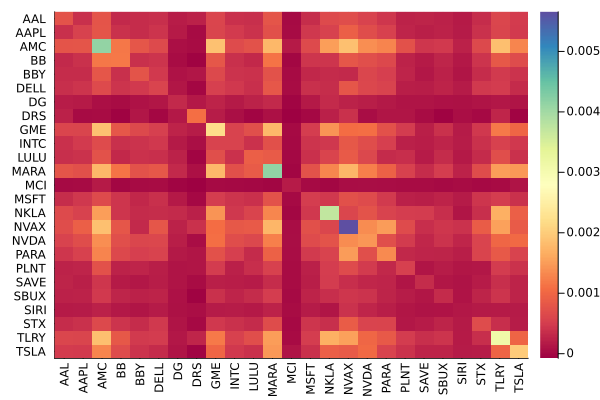

In [13]:
idx = 1
display(plot(covs[idx]; st = :heatmap, clim = extrema(covs[idx]),
             yticks = (1:N, portfolio.assets), xticks = (1:N, portfolio.assets),
             xrotation = 90, colorbar = true, xlim = (0.5, N + 0.5), ylim = (0.5, N + 0.5),
             color = cgrad(:Spectral), yflip = true))

However, it is easier to see the structure if we use the correlation. We've set the limits to go from 0 to 1 `clim = (0, 1)`, since all these assets appear to be postively correlated. Strictly speaking, only `CorMutualInfo`, `CorDistance` and `CorLTD` are guaranteed to be only positive. More information on all the methods is found in the docs.

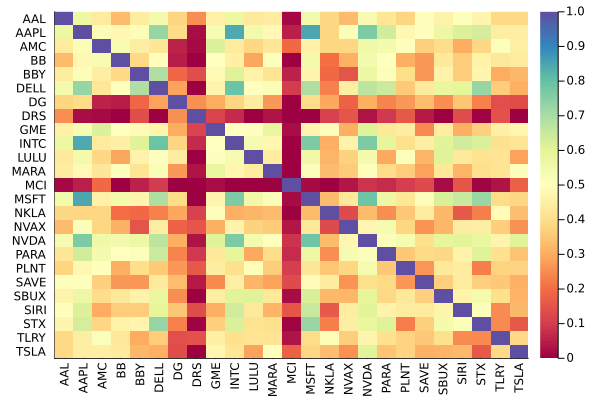

In [14]:
display(plot(cov2cor(covs[idx]); st = :heatmap, clim = (0, 1),
             yticks = (1:N, portfolio.assets), xticks = (1:N, portfolio.assets),
             xrotation = 90, colorbar = true, xlim = (0.5, N + 0.5), ylim = (0.5, N + 0.5),
             color = cgrad(:Spectral), yflip = true))

The next tutorial will go over the internals of `PortCovCor` and how they can be used to obtain cleaner covariance matrices. Though the Gerber and its modified methods work well without anything else.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*